In [1]:
import re
import spacy
import numpy as np
import pandas as pd
import en_core_web_sm
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
import nltk
nltk.download('wordnet')
nlp = en_core_web_sm.load()
lemmatizer = WordNetLemmatizer()
stopwords = STOP_WORDS
EMOJI_PATTERN = re.compile(
    "["
    u"U0001F600-U0001F64F"  # emoticons
    u"U0001F300-U0001F5FF"  # symbols & pictographs
    u"U0001F680-U0001F6FF"  # transport & map symbols
    u"U0001F1E0-U0001F1FF"  # flags (iOS)
    u"U00002702-U000027B0"
    u"U000024C2-U0001F251"
    "]+", flags=re.UNICODE
)
FILTERS = '!"#$%&()*+,-/:;?@[\]^_`{|}~tn'
HTML_TAG_PATTERN = re.compile(r']*>')
NUMBERING_PATTERN = re.compile('d+(?:st|[nr]d|th)')
DISABLE_PIPELINES = ["tok2vec", "parser", "ner", "textcat", "custom", "lemmatizer"]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
!git clone https://github.com/illliyas/Machine-Learning.git

Cloning into 'Machine-Learning'...
remote: Enumerating objects: 1637, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 1637 (delta 26), reused 6 (delta 2), pack-reused 1583
Receiving objects: 100% (1637/1637), 303.74 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Checking out files: 100% (1539/1539), done.


In [3]:
imdb_data = pd.read_csv('Machine-Learning/RNN/IMDB Dataset.csv')
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
def initial_preprocessing(text):

    """

    - Remove HTML tags

    - Remove Emojis

    - For numberings like 1st, 2nd

    - Remove extra characters > 2 eg:

    ohhhh to ohh

    """

    tag_removed_text = HTML_TAG_PATTERN.sub('', text)

    emoji_removed_text = EMOJI_PATTERN.sub(r'', tag_removed_text)

    numberings_removed_text =  NUMBERING_PATTERN.sub('', emoji_removed_text)

    extra_chars_removed_text = re.sub(

        r"(.)1{2,}",  r'11', numberings_removed_text

    )

    return extra_chars_removed_text

def preprocess_text(doc):

    """

    Removes the 

    1. Spaces

    2. Email

    3. URLs

    4. Stopwords

    5. Punctuations

    6. Numbers

    """

    tokens = [

        token

        for token in doc

        if not token.is_space and

           not token.like_email and

           not token.like_url and

           not token.is_stop and

           not token.is_punct and

           not token.like_num

    ]

    """

    Remove special characters in tokens except dot

    (would be useful for acronym handling)

    """

    translation_table = str.maketrans('', '', FILTERS)

    translated_tokens = [

        token.text.lower().translate(translation_table)

        for token in tokens

    ]

    """

    Remove integers if any after removing 

    special characters, remove single characters 

    and lemmatize

    """

    lemmatized_tokens = [

        lemmatizer.lemmatize(token)

        for token in translated_tokens

        if len(token) > 1

    ]

    return lemmatized_tokens

labels = imdb_data['sentiment'].iloc[:10000]

labels = labels.map(lambda x: 1 if x=='positive' else 0)

"""

Preprocess the text data

"""

data = imdb_data.iloc[:10000, :]

column = 'review'

not_null_data = data[data[column].notnull()]

not_null_data[column] = not_null_data[column].apply(initial_preprocessing)

texts = [

    preprocess_text(doc)

    for doc in nlp.pipe(not_null_data[column], disable=DISABLE_PIPELINES)

]

First of all, we are taking the first 10000 rows of data. The label/ target in this data is the column named ‘sentiment’. The sentiment column consists of two unique values namely ‘positive’ and ‘negative’ indicating the sentiment of the corresponding reviews. We are replacing the value ‘positive’ with integer 1 and the value ‘negative’ with integer 0.

We are taking only the rows which are not null which means we are omitting the reviews with null values. After obtaining the not null reviews we are applying the initial preprocessing function defined above.

The steps followed by the method initial preprocessing are,

* Removing HTML tags like , and extracting the data defined inside the tag
* Removing the emojis in the data
* Removing the numbering patterns in the data like 1st, 2nd, 3rd, and etc.
* Removing extra characters in the word. For example, the word ohhh is replaced with ohh.

After applying the initial preprocessing steps we are using spacy to preprocess the data. The steps followed by the preprocess method are,

* Removing spaces in the data.
* Removing emails in the data.
* Removing stopwords in the data.
* Removing URLs in the data.
* Removing punctuations in the data.
* Removing numbers in the data.
* Lemmatization.

The function nlp.pipe will produce series of doc objects in spaCy. A doc in spaCy is a sequence of token objects. We used disable pipelines to speed up the preprocessing time.

Lemmatization is the process of finding the root of the word. For example, the lemma of the word running would be run, which is the root of the word running. The purpose of doing lemmatization is to decrease the size of the vocabulary. To lemmatize the words we have used WordNetLemmatizer from the nltk package.

In [5]:
tokenizer = Tokenizer(
    filters=FILTERS,
    lower=True
)
padding = 'post'
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1
sequences = []
max_sequence_len = 0
for text in texts:
    # convert texts to sequence
    txt_to_seq = tokenizer.texts_to_sequences([text])[0]
    sequences.append(txt_to_seq)
    # find max_sequence_len for padding
    txt_to_seq_len = len(txt_to_seq)
    if txt_to_seq_len > max_sequence_len:
        max_sequence_len = txt_to_seq_len
# post padding
padded_sequences = pad_sequences(
    sequences, 
    maxlen=max_sequence_len, 
    padding=padding
)

After performing the preprocessing we are going to tokenize the data, convert the tokenized words to sequences, and pad the tokenized sentences. Tokenization is the process of breaking down a sentence into a sequence of words. For example, “I like apples” can be tokenized to [“I”, “like”, “apples”]. Converting the tokenized sentences into sequences would look like [1, 2, 3]. The words “i”, “like”, and “apples” are mapped to the numbers 1, 2, and 3. Then padding the sequences would look like [1, 2, 3, 0, 0, 0]. The three zeros after the number 3 are the padded sequences. This is also called post padding.

In [ ]:
max_sequence_len

840

In [6]:
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_sequence_len))
model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
adam = Adam(learning_rate=0.01)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer=adam, 
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 840, 64)           3222976   
                                                                 
 bidirectional (Bidirectiona  (None, 840, 128)         66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 840, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

In [7]:
padded_sequences.shape

(10000, 840)

In [8]:
history = model.fit(
    padded_sequences, 
    labels.values, 
    epochs=10,
    verbose=1,
    batch_size=64
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


157/157 [==============================] - 76s 399ms/step - loss: 0.6090 - accuracy: 0.6710
Epoch 2/10
157/157 [==============================] - 61s 385ms/step - loss: 0.3711 - accuracy: 0.8547
Epoch 3/10
157/157 [==============================] - 61s 388ms/step - loss: 0.1991 - accuracy: 0.9313
Epoch 4/10
157/157 [==============================] - 61s 388ms/step - loss: 0.1054 - accuracy: 0.9700
Epoch 5/10
157/157 [==============================] - 60s 383ms/step - loss: 0.0576 - accuracy: 0.9837
Epoch 6/10
157/157 [==============================] - 60s 385ms/step - loss: 0.0191 - accuracy: 0.9959
Epoch 7/10
157/157 [==============================] - 61s 386ms/step - loss: 0.0084 - accuracy: 0.9979
Epoch 8/10
157/157 [==============================] - 61s 391ms/step - loss: 0.0100 - accuracy: 0.9972
Epoch 9/10
157/157 [==============================] - 61s 391ms/step - loss: 0.0140 - accuracy: 0.9963
Epoch 10/10
157/157 [==============================] - 61s 390ms/step - loss: 0.0062

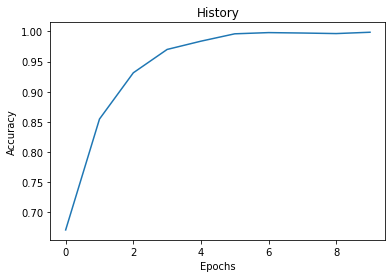

In [15]:
import matplotlib.pyplot as plt
fig = plt.plot(history.history['accuracy'])
title = plt.title("History")
xlabel = plt.xlabel("Epochs")
ylabel = plt.ylabel("Accuracy")

In [9]:
predictions = model.predict(padded_sequences[:4])
for pred in predictions:
    print(pred[0])

0.9999548
0.9999728
0.9999434
1.0682146e-05


In [14]:
data[:4]

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
